# Analysis of User Behavior for product at different prices.

## Introduction

### Tasks

    * Should the company sell its software for $59 or $39?
    * What are some actionable insights on user behavior that may increase conversion rates.
    * [Bonus] How many users do we need to test to measure a statistically significant difference? 


## Summary of Findings

Overall Findings: Determinable, but need more time. 

A very simple analysis finds that during the three month period during which this test took place, overall revenue would increase, if the software was sold at a higher price, by $44k

**However, this ignores issues related to the design of the test. **

By eye, the users in the high-priced group appear to be similar to users in the low-price group when comparing the platform that the users are working from (mobile or web) and the operating system. However, by using a chi^2 statistical test to assess whether or not the high priced test group represents the user population, I found that the test group does not represent the population as a whole. The next steps would be to resample from the high-priced test group in such a way as to match the representation of the user population and then use that new sample of test group to estimate the conversion rate and overall revenue change.

<br>
<br>

## Testing Increased Revenue for different prices

We have a simple test of two cohorts of users that were shown different prices. The higher price (\$59) is designated at group B and the lower price (\$39) is designated at group A. The ultimate goal is to determine if it is more profitable to sell the software at the higher price. That is

`R_hi > R_low`

where

`R_x = price * conversion rate_x * N_users`  and `x = hi, low`

Almost certainly, one expects the conversion rate for the higher price to be lower, but it must be lower by a factor of 59/39 (1.51) in order for an overall drop in revenue. 

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [77]:
import scipy.stats

In [3]:
%matplotlib inline

In [4]:
!ls

Adam_Cox_week7challenge.ipynb test_results.csv
Pricing_Test_data.zip         user_table.csv


In [5]:
users = 'user_table.csv'
tests = 'test_results.csv'

In [6]:
usersdf = pd.read_csv(users)

In [7]:
usersdf.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [8]:
testsdf = pd.read_csv(tests)
testsdf.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [52]:
print("These data cover user tests between {} and {}.".format(testsdf.timestamp.min(), testsdf.timestamp.max()))

These data cover user tests between 2015-03-02 00:04:12 and 2015-05-31 23:59:45.


### Merge Tables

Given that the data set here is not large, the Dataframes are merged into a single Dataframe 

In [9]:
df = testsdf.merge(usersdf, on='user_id', how='left')

In [10]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


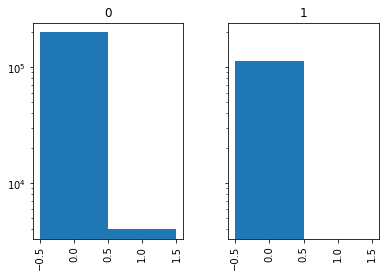

In [11]:
axs = df.hist(column='converted', by='test', bins=[-0.5,0.5,1.5], sharey = True, sharex=True, log=True)

In [12]:
c_hi = df[df.test == 1].converted.sum() / df[df.test == 1].test.count() 
print("Conversion rate for higher price = {}".format(c_hi))

Conversion rate for higher price = 0.015542678810936857


In [13]:
c_low = df[df.test == 0].converted.sum() / df[df.test == 0].test.count() 
print("Conversion rate for lower price = {}".format(c_low))

Conversion rate for lower price = 0.019903614220108817


### No duplicate users

There may be duplicate users in our dataset as they could have decided to puchase the software for different platforms. This should be something to investigate.  However, a simple check reveals there are no duplicate users.

In [14]:
df.user_id.count() / df.user_id.nunique()

1.0

### Basic Revenue Difference

In [15]:
R_low = 39 * c_low * df.user_id.count()

In [16]:
R_hi = 59 * c_hi * df.user_id.count()

In [17]:
R_low

245913.13441228843

In [18]:
R_hi

290511.31819098297

In [135]:
R_hi - R_low

44598.18377869454

This data covers the 3 month period from March through May of 2015. Simple analysis shows a potential increase in revenue of $44598. 

### Similar Cohort Checks

Before any conclusions can be drawn, however, we must check to be certain that the characteristics of the users that were shown the higher price are the same as the users that were shown the lower price. That is, given the total population of our users, do the distribution of the characterisics of the users in the two groups appear to have been sampled randomly from the total distribution? 

In [20]:
df.nunique()

user_id             316800
timestamp           140931
source                  12
device                   2
operative_system         6
test                     2
price                    2
converted                2
city                   923
country                  1
lat                    713
long                   830
dtype: int64

### Device and Operating System

We'll just first consider device and operating system and ignore the advertising source of the user.

In [107]:
def describe_categories(df, columnname):
    s = df[columnname].value_counts()
    print(s)
    print('\n')
    print("Relative Frequency")
    for indx in s.index:
        print('{}: {:0.3}'.format(indx, s[indx]/s.sum()))
        
def chisqtest(df, columnname):
    for i in [0,1]:
        price = "Low"
        if i == 1:
            price = "High"
        print("{} Price Group ChiSq Test".format(price))
        expected_dist = df[df.test==i][columnname].value_counts().sum() * df[columnname].value_counts()/df[columnname].value_counts().sum()
        r,p = scipy.stats.chisquare(df[df.test==i][columnname].value_counts(), expected_dist)
        print('chiSq: {}, p-val: {}'.format(r,p))
        print('\n')
        print("")
        

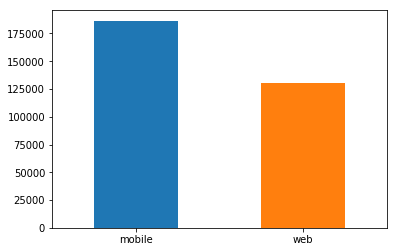

In [31]:
ax = df['device'].value_counts().plot(kind='bar', rot=0)

In [108]:
describe_categories(df, 'device')

mobile    186471
web       130329
Name: device, dtype: int64


Relative Frequency
mobile: 0.589
web: 0.411


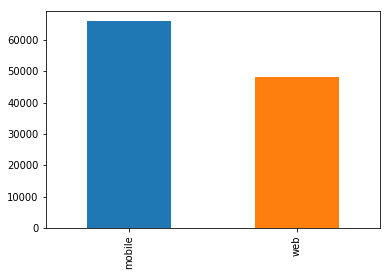

In [32]:
df[df.test==1].device.value_counts().plot(kind = 'bar', sharex = True)

In [73]:
describe_categories(df[df.test==1], 'device')

mobile    65990
web       48083
Name: device, dtype: int64


Relative Frequency
mobile: 0.578
web: 0.422


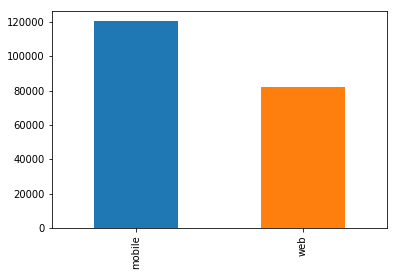

In [34]:
df[df.test==0].device.value_counts().plot(kind = 'bar', sharex = True)

In [74]:
describe_categories(df[df.test==0], 'device')

mobile    120481
web        82246
Name: device, dtype: int64


Relative Frequency
mobile: 0.594
web: 0.406


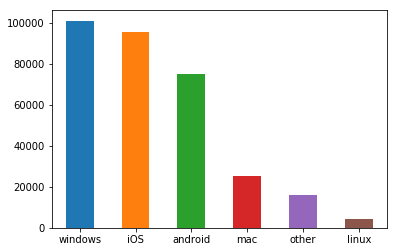

In [47]:
ax = df['operative_system'].value_counts().plot(kind='bar', rot=0)

In [75]:
describe_categories(df, 'operative_system')

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: operative_system, dtype: int64


Relative Frequency
windows: 0.319
iOS: 0.301
android: 0.237
mac: 0.0792
other: 0.0511
linux: 0.0131


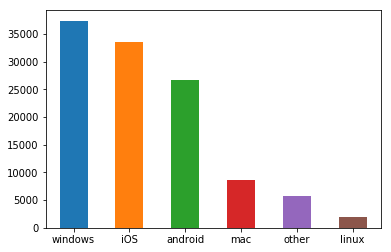

In [48]:
ax = df[df.test==1].operative_system.value_counts().plot(kind='bar', rot=0)

In [110]:
describe_categories(df[df.test==1], 'operative_system')

windows    37385
iOS        33610
android    26725
mac         8719
other       5706
linux       1928
Name: operative_system, dtype: int64


Relative Frequency
windows: 0.328
iOS: 0.295
android: 0.234
mac: 0.0764
other: 0.05
linux: 0.0169


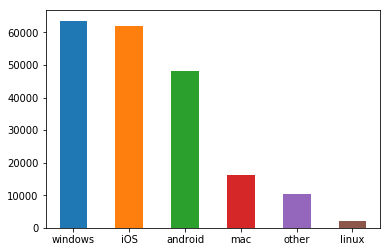

In [111]:
ax = df[df.test==0].operative_system.value_counts().plot(kind='bar', rot=0)

## Distribution Testing

### By Eye

Analysis "by eye" of low/high price cohorts appears to suggest that these cohorts are representative of the population as a whole. 

## Quantitative Distribution Test
TODO: Make a quantitative assessment of whether the distrubtion of the characteristics of test/no-test cohorts appear to be sampled from the overall population.

A Chi-sq test statistic is a good place to start comparing these distributions.



In [109]:
chisqtest(df, 'device')

Low Price Group ChiSq Test
chiSq: 27.140954570671077, p-val: 1.8914812781795878e-07


High Price Group ChiSq Test
chiSq: 48.23406325115038, p-val: 3.7825998940897214e-12




In [112]:
chisqtest(df, 'operative_system')

Low Price Group ChiSq Test
chiSq: 107.82240325263486, p-val: 1.1818749650171817e-21


High Price Group ChiSq Test
chiSq: 191.61863319275287, p-val: 1.761162125158637e-39




I'm suspicious of the results above. The p-values seem way too small given how close these distributions appear to be correct by eye. 

<br>

### Next Steps
Assuming that these estimates of the chi^2 test are correct in that the test group does not represent the population as a whole, the next best thing to do would be to resample from the test population a new test group that represents the overall population.

## Who pays more?

Next, one should look at which group of users purchase the higher priced software the most. For example, should the business focus more effort on advertising and selling to Android users? 

## Buyer Location

We can also examine where our buyers are located and see if there are differences.

In [114]:
from mpl_toolkits.basemap import Basemap

In [116]:
plt.show()

/Users/adam/anaconda3/envs/week7challenge/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/adam/anaconda3/envs/week7challenge/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/adam/anaconda3/envs/week7challenge/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/adam/anaconda3/envs/week7challenge/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document 

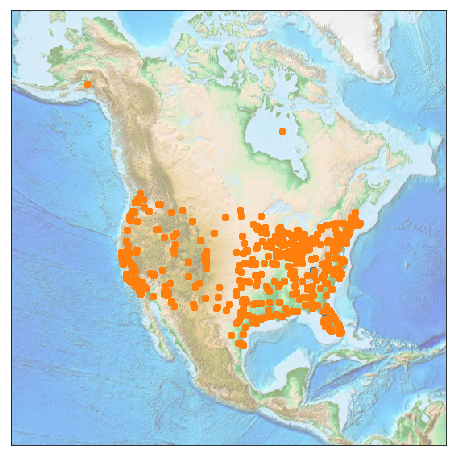

In [138]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
           width=8E6, height=8E6,
           lat_0=45, lon_0=-100,)


m.etopo(scale=0.5, alpha=0.5)
   
lat_testers = df[df.test == 1].lat.dropna().values
long_testers = df[df.test == 1].long.dropna().values

x, y = m(long_testers, lat_testers)

m.scatter(x, y)#, #latlon=True,
                      #c=np.log10(population), s=area,
                      #cmap='Reds', alpha=0.5)
        
lat_testers = df[df.test == 0].lat.dropna().values
long_testers = df[df.test == 0].long.dropna().values
x, y = m(long_testers, lat_testers)

m.scatter(x, y)#, #latlon=True,
                      #c=np.log10(population), s=area,
                      #cmap='Reds', alpha=0.5)